In [1]:
%matplotlib inline
from Bio import SeqIO
import os
import subprocess
import random
from itertools import islice
from collections import Counter
from datetime import datetime as time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import math

original_targets = "./no_nag_targets.fasta"
# targets based of genome-wide mapping of potential off-target effects. List taken from DiCarlo et al, only unique 
# seed sequences and no NAG alternative PAMs

yeast_CDS_fasta = './orf_coding_all_R64-1-1_20110203.fasta'
# yeast orfs


## Aligning guides with unique seeds on BY4741 CDS

In [2]:
print 'starting Bowtie with specified parameters', time.now()


########## Bowtie parameters #############
base_command = 'bowtie '

align_parameters = '-v 0 -t -f -p 6 '
# -q: input is fastq
# -v 1: allow at most 1 mismatch in read
# -y: tryhard for the best alignment
# -t: show time for steps
# -p 6: multithread

output_parameters = '-m 1 --best '
#-k 1: only one alignement reported for each read
#-m : suppress reads with more than one alignments
#-S : SAM format output
#--no-unal: suppress reads that did not align


in_fasta = original_targets + ' ' 

index = 'BY4741 '

cds_alignment_output = './targets_align.txt'

bowtie_command = base_command+align_parameters+output_parameters+index+in_fasta+cds_alignment_output

print bowtie_command

subprocess.check_output(bowtie_command, stdin=None, stderr=subprocess.STDOUT, shell=True, universal_newlines=True)

print 'finished Bowtie with specified parameters', time.now()



starting Bowtie with specified parameters 2017-12-20 10:07:46.976600
bowtie -v 0 -t -f -p 6 -m 1 --best BY4741 /home/phdes74/Dropbox/Crispr_PCA_PI_Regulator_Screen/refs/DiCarlo_et_al/no_nag_targets.fasta /home/phdes74/Dropbox/Crispr_PCA_PI_Regulator_Screen/yeast_genome/targets_align.txt
finished Bowtie with specified parameters 2017-12-20 10:07:48.556166


## Building a dictionnary of gRNA seqs

In [3]:
guide_dict = {}


with open(original_targets, 'r') as source:
    
    for line in source:
        
        if line.startswith('>'):
            
            guide_name = line.strip('>').strip('\n').strip('_NoNAG')
            
        else:
            
            guide_seq = line.strip('\n')
            
            guide_dict[guide_name] = guide_seq

print list(islice(guide_dict, 10))

print len(guide_dict)
            
print guide_dict['chrI_205r']

print guide_dict['chrXVI_942301']

print guide_dict['chrXVI_942301'][1:4]

 

['chrIV_1338684', 'chrXVI_924519r', 'chrXI_38769r', 'chrXV_364911r', 'chrXII_577638', 'chrX_391358r', 'chrXIV_273271r', 'chrVII_987863r', 'chrXII_577633', 'chrIV_564773r']
645392
GGAGGGTAACGGTGGGTGAG
GTGGATGATCATGAATGTTA
TGG


In [4]:
AID_targets = 0

for seq in guide_dict.values():
    if 'C' in seq[1:4]:
        AID_targets += 1
        
print AID_targets



    

306110


## Gathering info on yeast orfs

In [5]:
orf_dict = {}

orf_len_dict = {}


input_file = open(yeast_CDS_fasta)
orf_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))

for orf, seq in orf_dict.iteritems():
    
    orf_len = len(seq.seq)
    
    orf_len_dict[(orf.upper())] = orf_len
    
print orf_dict['YAL008W']
print orf_len_dict['YAL008W']

print np.mean(orf_len_dict.values())
# mean length in pb of orfs in annotation file.

print 'number of annotated orfs in file ' + str(len(orf_dict.keys()))


prot_cds_nb = 0

for orf in orf_dict.keys():
    if orf.startswith('Y'):
        prot_cds_nb += 1
        
print 'number of annotated proteins in file ' + str(prot_cds_nb)
        

ID: YAL008W
Name: YAL008W
Description: YAL008W FUN14 SGDID:S000000006, Chr I from 136914-137510, Verified ORF, "Mitochondrial protein of unknown function"
Number of features: 0
Seq('ATGACTTTGGCTTTTAATATGCAACGGTTGGTGTTTCGTAATTTGAATGTTGGG...TGA', SingleLetterAlphabet())
597
1351.93121929
number of annotated orfs in file 6717
number of annotated proteins in file 6685


## High fitness effects non lethal genes

In [7]:
fit_effects = './fitness_effects.csv'
ftab = pd.read_csv(fit_effects)

ftab['YPD_1'] = ftab['YPD rep1 fitness']
ftab['YPD_2'] = ftab['YPD rep2 fitness']
ftab['YPG'] = ftab['YPG fitness']
ftab['ETH'] = ftab['ETH fitness']
ftab['OAK'] = ftab['OAK fitness']
ftab['SC'] = ftab['SC fitness']

ftab['mean_effect'] = (ftab['YPD_1']+ftab['YPD_2']+ftab['YPG']+ftab['ETH']+ftab['OAK']+ftab['SC'])/6

high_effect = ftab.loc[lambda df: df['mean_effect'] < .75, :]

no_gain = ftab.loc[lambda df: df['mean_effect'] < 1.001, :]
print len(no_gain)
no_loss = ftab.loc[lambda df: df['mean_effect'] > 0.999, :]
print len(no_loss)


high_effect_list = [x for x in high_effect['ORF']]

no_gain_list = [x for x in no_gain['ORF']]

no_effect_list = [x for x in no_loss['ORF']if x in no_gain_list]

print len(high_effect_list)
print len(no_effect_list)

random.seed(4)

non_essential_no_effect = random.sample(no_effect_list, 38)
print len(non_essential_no_effect)

print high_effect_list

print non_essential_no_effect


3183
1444
175
178
38
['YAL002W', 'YAL021C', 'YAL035W', 'YAL047C', 'YAR015W', 'YBL006C', 'YBL007C', 'YBL038W', 'YBL058W', 'YBL093C', 'YBR036C', 'YBR126C', 'YBR127C', 'YBR200W', 'YBR268W', 'YBR279W', 'YBR282W', 'YBR289W', 'YCL007C', 'YCL016C', 'YCR009C', 'YCR020W-B', 'YCR028C-A', 'YCR044C', 'YCR047C', 'YDL006W', 'YDL041W', 'YDL075W', 'YDL090C', 'YDL115C', 'YDL160C', 'YDL185W', 'YDL191W', 'YDR017C', 'YDR027C', 'YDR065W', 'YDR069C', 'YDR129C', 'YDR138W', 'YDR173C', 'YDR175C', 'YDR176W', 'YDR195W', 'YDR207C', 'YDR226W', 'YDR245W', 'YDR264C', 'YDR323C', 'YDR359C', 'YDR388W', 'YDR432W', 'YDR433W', 'YDR448W', 'YDR477W', 'YDR484W', 'YDR495C', 'YDR532C', 'YEL027W', 'YEL029C', 'YEL036C', 'YEL044W', 'YEL051W', 'YER014C-A', 'YER019W', 'YER044C', 'YER068W', 'YER083C', 'YER155C', 'YFR019W', 'YGL058W', 'YGL070C', 'YGL071W', 'YGL076C', 'YGL095C', 'YGL115W', 'YGL135W', 'YGL167C', 'YGL240W', 'YGL246C', 'YGR020C', 'YGR078C', 'YGR104C', 'YGR105W', 'YGR155W', 'YGR160W', 'YGR165W', 'YGR167W', 'YGR180C', 'YGR

## Controls: essential genes

In [8]:
essential_orfs= './Essential_ORFs.txt'
# The list of esentials orf according to the yeast KO collection website: 
# http://www-sequence.stanford.edu/group/yeast_deletion_project/Essential_ORFs.txt
# The header was removed from the file

essential_orf_list = []

with open(essential_orfs, 'r') as source:
    
    for line in source:
        
        if line.startswith('2') == True:
            line = line.split('\t')

            orf = line[1].replace(' ','')
            orf = orf.upper()


            essential_orf_list.append(orf)
        
print essential_orf_list[0]
print len(essential_orf_list)


#random.seed(3)
#essential_controls = random.sample(essential_orf_list, 300)


#for control in essential_controls:
#    essential_orf_list.remove(control)
    
print len(essential_orf_list)


def check_if_essential(orf):
    if orf in essential_orf_list:
        return True
        
    else:
        return False


print check_if_essential('YAL001C')
print check_if_essential('YJL154C')


YAL001C
1156
1156
True
False


## Controls: introns

### A database of yeast introns

In [9]:
intron_db = './yeast_introns.txt'
# copy_paste from http://intron.ucsc.edu/yeast4.3/ with last empty line removed

intron_fasta_file = './yeast_introns.fasta'


intron_dict = {}

with open(intron_db, 'r') as source:
    
    for line in source:
        
        line= line.split('\t')
    
        
        orf_name = line[1].upper()
        
        intron_seq = line[5].strip('\n')
        
        intron_dict[orf_name] = intron_seq
        
        
print intron_dict['YHR012W']


with open(intron_fasta_file, 'w') as write_out:
    
    nb_introns = 0
    
    for orf, intron in intron_dict.iteritems():

        fasta_header = '>' + orf + '\n'
        intron_seq = intron + '\n'
        
        write_out.write(fasta_header)
        write_out.write(intron_seq)
        
        nb_introns += 1
    

########## Build index ##########

index_command = 'bowtie-build -r --ntoa -o 2 '

# -r: no index for pairend end (useless in this case!)
# -ntoa: converts Ns to As so they are indexed
# -o 3: marks every 8th row (vs 32nd as default)


source = './yeast_introns.fasta '

index_name = 'yeastintrons'

index_build = index_command+source+index_name

print index_build

subprocess.check_output(index_build, stdin=None, stderr=None, shell=True, universal_newlines=False)




GTATGTGTTATTCTCCTTTCTTCTCTGGTTAGCTGTAGTGGAACCTATAACGGCCATTGCGCCACAACTTCCTTTAACATTAATACTAACATATTGATAACGACTTCAATTGCAAGTAG
bowtie-build -r --ntoa -o 2 /home/phdes74/Dropbox/Crispr_PCA_PI_Regulator_Screen/yeast_genome/yeast_introns.fasta yeastintrons


### Finding high quality guides that target introns

In [10]:
print 'starting Bowtie with specified parameters', time.now()


########## Bowtie parameters #############
base_command = 'bowtie '

align_parameters = '-v 0 -t -f -p 6 '
# -q: input is fastq
# -v 1: allow at most 1 mismatch in read
# -y: tryhard for the best alignment
# -t: show time for steps
# -p 6: multithread

output_parameters = '-m 1 --best '
#-k 1: only one alignement reported for each read
#-m : suppress reads with more than one alignments
#-S : SAM format output
#--no-unal: suppress reads that did not align


in_fasta = './no_nag_targets.fasta ' 

index = 'yeastintrons '

intron_alignment_output = './yeast_introns_align.txt'

bowtie_command = base_command+align_parameters+output_parameters+index+in_fasta+intron_alignment_output

print bowtie_command

subprocess.check_output(bowtie_command, stdin=None, stderr=subprocess.STDOUT, shell=True, universal_newlines=True)

print 'finished Bowtie with specified parameters', time.now()



starting Bowtie with specified parameters 2017-12-20 10:07:50.895936
bowtie -v 0 -t -f -p 6 -m 1 --best yeastintrons /home/phdes74/Dropbox/Crispr_PCA_PI_Regulator_Screen/refs/DiCarlo_et_al/no_nag_targets.fasta /home/phdes74/Dropbox/Crispr_PCA_PI_Regulator_Screen/yeast_genome/yeast_introns_align.txt
finished Bowtie with specified parameters 2017-12-20 10:07:51.362122


### Building the set of introns targeting guides

In [11]:
intron_guides_align = './yeast_introns_align.txt'

intron_guides_dict = {}

intron_writ_list = []

intron_anomaly = ['chrII_691982', 'chrII_691983', 'chrII_692006', 'chrXII_40226']

with open(intron_guides_align) as source:
    
    for line in source:
        
        line = line.split('\t')
        
        guide_name = line[0].strip('_NoNAG')
        
        target_orf = (line[2].upper()) +'_intron'
        
        pos = line[3]
        
        target_strand = line[1]
        
        
        
        if 'C' in guide_dict[guide_name][1:4] and 'CCC' != guide_dict[guide_name][1:4] and 'CC' != guide_dict[guide_name][2:4]:
            
        
            intron_dna_seq = guide_dict[guide_name]
            
            intron_guides_dict[guide_name] = target_orf
            
            
            intron_writ_line = guide_name+'\t'+'intron'+'\t'+target_orf+'\t'+pos+'\t'+target_strand+'\t'+intron_dna_seq
            
            if guide_name not in intron_anomaly:
                
            
                intron_writ_list.append(intron_writ_line)
         
        
print nb_introns
# number of introns in database       
print len(intron_guides_dict)
# number of ok guides targeting introns
print float(len(intron_guides_dict))/nb_introns
# average number of guides/intron


print len(intron_writ_list)
print intron_writ_list[2]



281
998
3.55160142349
994
chrI_142417r	intron	YAL003W_intron	166	-	TCTTTTGTCACTCATATCGG


## Controls: putative non functional peptides

### A set of putative non-functionnal peptides and their bowtie index

In [12]:
put_non_fun = './R64-2-1_unannot_translated_ORFs_over_80nt.fasta'
# set of 304 putative non-functionnal expressed peptides from Nielly-Thibault et al 2017, all over 80nts long


########## Build index ##########

index_command = 'bowtie-build -r --ntoa -o 2 '

# -r: no index for pairend end (useless in this case!)
# -ntoa: converts Ns to As so they are indexed
# -o 3: marks every 8th row (vs 32nd as default)


source = './R64-2-1_unannot_translated_ORFs_over_80nt.fasta '

index_name = 'yeastputnonfun80nt '

index_build = index_command+source+index_name

print index_build

subprocess.check_output(index_build, stdin=None, stderr=None, shell=True, universal_newlines=False)



bowtie-build -r --ntoa -o 2 /home/phdes74/Dropbox/Crispr_PCA_PI_Regulator_Screen/yeast_genome/R64-2-1_unannot_translated_ORFs_over_80nt.fasta yeastputnonfun80nt 


### Finding high quality guides that target the NFs

In [13]:
print 'starting Bowtie with specified parameters', time.now()


########## Bowtie parameters #############
base_command = 'bowtie '

align_parameters = '-v 0 -t -f -p 6 '
# -q: input is fastq
# -v 1: allow at most 1 mismatch in read
# -y: tryhard for the best alignment
# -t: show time for steps
# -p 6: multithread

output_parameters = '-m 1 --best '
#-k 1: only one alignement reported for each read
#-m : suppress reads with more than one alignments
#-S : SAM format output
#--no-unal: suppress reads that did not align


in_fasta = './no_nag_targets.fasta ' 

index = 'yeastputnonfun80nt '

nf_alignment_output = './yeast_putnonfun80nts_align.txt'

bowtie_command = base_command+align_parameters+output_parameters+index+in_fasta+nf_alignment_output

print bowtie_command

subprocess.check_output(bowtie_command, stdin=None, stderr=subprocess.STDOUT, shell=True, universal_newlines=True)

print 'finished Bowtie with specified parameters', time.now()



starting Bowtie with specified parameters 2017-12-20 10:07:52.149376
bowtie -v 0 -t -f -p 6 -m 1 --best yeastputnonfun80nt /home/phdes74/Dropbox/Crispr_PCA_PI_Regulator_Screen/refs/DiCarlo_et_al/no_nag_targets.fasta /home/phdes74/Dropbox/Crispr_PCA_PI_Regulator_Screen/yeast_genome/yeast_putnonfun80nts_align.txt
finished Bowtie with specified parameters 2017-12-20 10:07:52.579516


### Building the set of NFs targeting guides

In [14]:
nf_guides_align = './yeast_putnonfun80nts_align.txt'

nf_guides_dict = {}

nf_writ_list = []

with open(nf_guides_align) as source:
    
    for line in source:
        
        line = line.split('\t')
        
        guide_name = line[0].strip('_NoNAG')
        
        target_orf = (line[2].upper())+'_nf'
        
        pos = line[3]
        
        target_strand = line[1]
        
        if 'C' in guide_dict[guide_name][1:4] and 'CCC' != guide_dict[guide_name][1:4] and 'CC' != guide_dict[guide_name][2:4]:
            
            nf_dna_seq = guide_dict[guide_name]
            
            nf_guides_dict[guide_name] = target_orf
            
            nf_writ_line = guide_name+'\t'+'putative_NF'+'\t'+target_orf+'\t'+pos+'\t'+target_strand+'\t'+nf_dna_seq
            
            nf_writ_list.append(nf_writ_line)
            

            
        
print 304
# number of NFs in database       
print len(nf_writ_list)
# number of ok guides targeting NFs
print nf_writ_list[2]

304
621
chrI_175513r	putative_NF	CHRI_+_175429_175561_nf	86	-	GCTCTAATACGGCTTTTCTG


## Exceptions

### ORFs That should not be targeted

In [15]:
auxotrophy_markers = ['YOR202W', 'YCL018W', 'YLR303W', 'YEL021W', 'YBR115C', 'YEL063C', 'YNL268W', 'YPR062W']

# YOR202W is HIS3
# YCL018W is LEU2
# YLR303W is MET15 or MET17
# YEL021W is URA3
# YBR115C is LYS2

# YEL063C is CAN1
# YNL268W is LYP1
# YPR062W is FCY1

def check_if_marker(orf):
    if orf in auxotrophy_markers:
        return True
    else:
        return False
    
exception_orfs = ['YAR015W', 'YOR128C', 'YNL220W', 'YDL227C', 'YOR069W', 'YJL154C', 'YOR132W', 'YHR012W', 'YJL053W']


def check_if_exception(orf):
    if orf in exception_orfs or orf in high_effect_list or orf in non_essential_no_effect:
        return True
    else:
        return False


### Sequences that should not be in guides

In [16]:
BsaI_cut_site_for = 'GGTCTC'
BsaI_cut_site_rev = 'GAGACC'

def check_if_restriction_site_ok(guide_seq):
    if BsaI_cut_site_for in guide_seq or BsaI_cut_site_rev in guide_seq:
        return False
    else:
        return True

In [17]:
# check for deaminase compatible codon. mut freq is assumed to be 60% C>T and 40% C>G

convert_to_stop_for = ['TCA','CAA']

convert_to_stop_rev = ['CCA']

## Cycling through the high quality guides

In [26]:
print time.now()



orf_good_guides = []
# list of orf names, where they have one mention added every time a good guide aligning to them is found. To be used
# with the counter functio

orf_guides_dict = {}
# format is orf_guides_dict[orf] = [guide_1, guide_2, guide_3, ...]

guide_position_dict = {}
# format is guide_position_dict[guide_name] = guide position in gene (in % of orf)

writ_line_list = []


x =0

with open(cds_alignment_output) as source:
    
    for line in source:
        
        line = line.split('\t')
        guide_name = line[0].strip('_NoNAG')
        
        target_orf = line[2].replace('_BY4741','')
        
        target_pos = float(line[3])
        
        target_strand = line[1]
        
        if target_orf.startswith('Y') == True and target_orf.upper() in orf_dict.keys():
            # checks if the gene is nuclear and in the assembly used for the alignment
            
            if check_if_essential(target_orf) == True or check_if_exception(target_orf) == True:
                # selects guides targeting essential genes
                
                if check_if_essential(target_orf) == True:
                    
                    orf_type = 'essential'
                    
                elif target_orf in high_effect_list:
                    
                    orf_type = 'high_effect'
                    
                elif target_orf in no_effect_list:
                    
                    orf_type = 'no_effect'
                    
                elif target_orf in exception_orfs:
                    
                    orf_type = 'exception'
                
                dna_seq = guide_dict[guide_name]
                
                if check_if_marker(target_orf) == False and check_if_restriction_site_ok(dna_seq):
                    
                    
                    
                                        
                    if 'C' in guide_dict[guide_name][1:4] and 'CCC' != guide_dict[guide_name][1:4] and 'CC' != guide_dict[guide_name][2:4]:
                        
                        target_len = orf_len_dict[target_orf]

                        target_pos_in_orf = (target_pos/target_len)*100
                        
                        if 75 >= target_pos_in_orf >= 0.5:
                            
                            pos = str(target_pos)

                            orf_good_guides.append(target_orf)
                        
                            guide_position_dict[guide_name] = target_pos_in_orf
                        
                        
                        
                            if target_orf not in orf_guides_dict.keys():

                                orf_guides_dict[target_orf] = [guide_name]

                            else:
                                orf_guides_dict[target_orf] += [guide_name]

                            
                            guide_line = guide_name+'\t'+orf_type+'\t'+target_orf+'\t'+pos+'\t'+target_strand+'\t'+dna_seq
                            
                            writ_line_list.append(guide_line)
                            
                            x +=1

                     
                    

                    
print x                  
           
orf_guide_nb = Counter(orf_good_guides)

print len(guide_position_dict.keys())

print len(orf_guides_dict.keys())



print time.now()

print writ_line_list[2]
          

2017-12-20 13:22:01.267551
38363
38363
1181
2017-12-20 13:23:11.185795
chrI_55655	high_effect	YAL047C	1183.0	-	GGTCTGAGTTTCCAGTTCTT


In [27]:
all_writ_lines = writ_line_list + nf_writ_list + intron_writ_list
print len(all_writ_lines)

39978


## Write the chip to file

In [20]:
guide_table_output = './yeast_essential_gene_chip_LandryLAB.tsv'

with open(guide_table_output, 'w') as dest:
    header = 'guide_name'+'\t'+'orf_type'+'\t'+'target'+'\t'+'position'+'\t'+'strand'+'\t'+'sequence'+'\n'
    dest.write(header)
    for line in all_writ_lines:
        dest.write((line+'\n'))
              
        
        

## Data on the chip!

In [21]:
chip_data_frame = pd.read_csv(guide_table_output, sep='\t')

occurence_list = [x for x in chip_data_frame['target']]

#per type
essential_nb = len([x for x in chip_data_frame['orf_type'] if x == 'essential'])
high_effect_nb = len([x for x in chip_data_frame['orf_type'] if x == 'high_effect'])
no_effect_nb = len([x for x in chip_data_frame['orf_type'] if x == 'no_effect'])
exception_nb = len([x for x in chip_data_frame['orf_type'] if x == 'exception'])
intron_nb = len([x for x in chip_data_frame['orf_type'] if x == 'intron'])
put_nf_nb = len([x for x in chip_data_frame['orf_type'] if x == 'putative_NF'])

print essential_nb, high_effect_nb, no_effect_nb, exception_nb, intron_nb, put_nf_nb

chip_stat = [essential_nb, high_effect_nb, no_effect_nb, exception_nb, intron_nb, put_nf_nb]

occurences_count = Counter(occurence_list)

duplicated = chip_data_frame.loc[lambda df: df.duplicated('guide_name', False) == True, :]


print min(occurences_count.values())
print max(occurences_count.values())



print duplicated

32324 4821 960 258 994 621
1
252
Empty DataFrame
Columns: [guide_name, orf_type, target, position, strand, sequence]
Index: []


In [16]:
import editdistance
import seaborn as sns

In [33]:
guide_table = pd.read_csv('./chip_table_with_muts.tsv', sep ='\t', index_col=0)

guide_table.head(10)

all_guides_ref = list(guide_table.sequence)

all_guides = list(guide_table.sequence)

print len(all_guides)

test = all_guides[0]


leveshtein_min_dict = {}
levestein_median_dict = {}

for guide in all_guides_ref:
    
        
    all_guides.remove(guide)
    
    
    leveshtein_list = []
      
    
    for other_guide in all_guides:
        
        leveshtein_list.append(editdistance.eval(guide, other_guide))
        
        
    leveshtein_min_dict[guide] = min(leveshtein_list)
    levestein_median_dict[guide] = np.median(leveshtein_list)
        
    all_guides = list(guide_table.sequence)
        
        


39978


In [52]:
print len(leveshtein_min_dict)

print min(leveshtein_min_dict.values())
print max(leveshtein_min_dict.values())

print min(levestein_median_dict.values())
print max(levestein_median_dict.values())

bins = [x-0.5 for x in range(0,15)]

39978
1
7
11.0
14.0


Text(0,0.5,'Density')

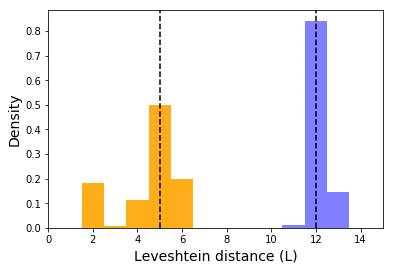

In [67]:
bins = [x-0.5 for x in range(0,15)]

plt.hist(leveshtein_min_dict.values(), density =True, bins = bins, color = 'orange', alpha = 0.9)
plt.hist(levestein_median_dict.values(), density =True, bins= bins, color = 'blue', alpha = 0.5)

plt.axvline(np.median(leveshtein_min_dict.values()), color = 'k', ls = '--')
plt.axvline(np.median(levestein_median_dict.values()), color = 'k', ls = '--')

plt.xlim(0,15)

plt.xlabel('Leveshtein distance (L)', fontsize = 14)
plt.ylabel('Density', fontsize = 14)

(array([991., 419., 138.,  29.,  13.,   6.,   2.,   0.,   0.,   1.]),
 array([  1. ,  26.1,  51.2,  76.3, 101.4, 126.5, 151.6, 176.7, 201.8,
        226.9, 252. ]),
 <a list of 10 Patch objects>)

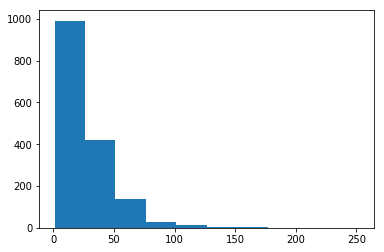

In [69]:
plt.hist(guide_table.groupby('target').count().strand)

In [87]:
target_labels = ['Essential', 'High effect', 'No effect', 'Putative NF', 'Introns']

target_nb = [len(guide_table[guide_table['orf_type'] == 'essential'].target.unique()),
             len(guide_table[guide_table['orf_type'] == 'high_effect'].target.unique()),
             len(guide_table[guide_table['orf_type'] == 'no_effect'].target.unique()),
             len(guide_table[guide_table['orf_type'] == 'putative_NF'].target.unique()),
             len(guide_table[guide_table['orf_type'] == 'intron'].target.unique()),]

guide_nb = [list(guide_table.orf_type).count('essential'), 
            list(guide_table.orf_type).count('high_effect'), 
            list(guide_table.orf_type).count('no_effect'),
            list(guide_table.orf_type).count('putative_NF'),
            list(guide_table.orf_type).count('intron')]



(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 <a list of 7 Text yticklabel objects>)

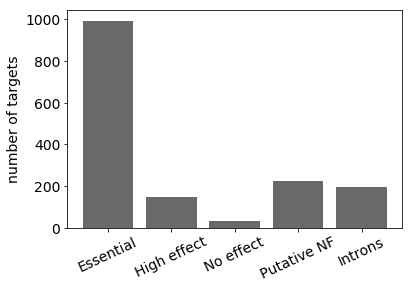

In [105]:
for x in range(0,5):
    
    plt.bar(x, target_nb[x], color = 'dimgrey')

plt.xticks([0,1,2,3,4], target_labels, rotation = 25, fontsize = 14)

plt.ylabel('Number of targets', fontsize = 14)
plt.yticks(fontsize = 14)

(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.]),
 <a list of 8 Text yticklabel objects>)

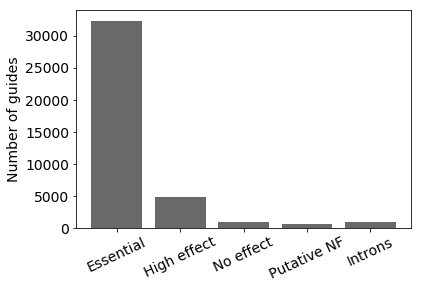

In [106]:
for x in range(0,5):
    
    plt.bar(x, guide_nb[x], color = 'dimgrey')

plt.xticks([0,1,2,3,4], target_labels, rotation = 25, fontsize = 14)

plt.ylabel('Number of guides', fontsize = 14)
plt.yticks(fontsize = 14)

Text(0,0.5,'Number of guides')

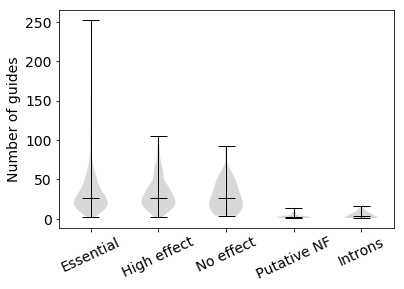

In [129]:
colors = ['k', 'r', 'g', 'b', 'm']

types = ['essential', 'high_effect', 'no_effect', 'putative_NF', 'intron']

bins = [x for x in np.arange(0,125,5)]

list_of_list = []

for category in types:
    
    subtable = guide_table[guide_table['orf_type'] == category]
    
    guide_per_gene_list = []
    
    for target in subtable.target.unique():
        
        guide_per_gene_list.append(list(subtable.target).count(target))
    
    list_of_list += [guide_per_gene_list]
    
violin_parts = plt.violinplot(list_of_list, showmedians=True)

# Make all the violin statistics marks black:
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = violin_parts[partname]
    vp.set_edgecolor('k')
    vp.set_linewidth(1)

# Make the violin body grey:
for vp in violin_parts['bodies']:
    vp.set_facecolor('grey')




plt.xticks([1,2,3,4,5], target_labels, rotation = 25, fontsize = 14)
plt.yticks(fontsize=14)

plt.ylabel('Number of guides', fontsize=14)

## Four panel fig

[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5]


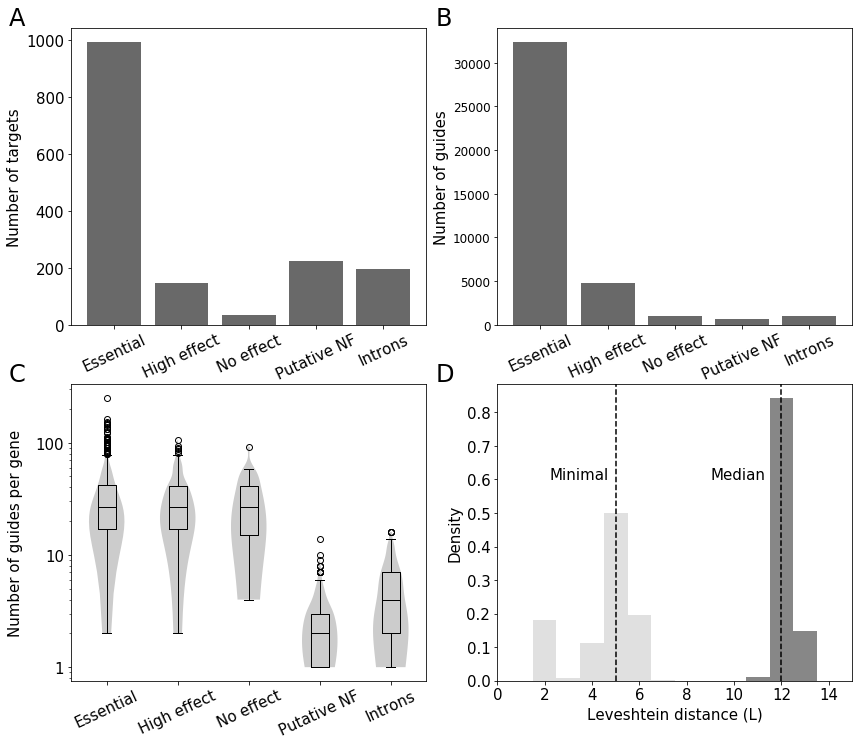

In [214]:


plt.figure(figsize = (14,12), dpi = 300)

ax = plt.subplot(221)

for x in range(0,5):
    
    plt.bar(x, target_nb[x], color = 'dimgrey')

plt.xticks([0,1,2,3,4], target_labels, rotation = 25, fontsize = 15)

plt.ylabel('Number of targets', fontsize = 15)
plt.yticks(fontsize = 15)

ax.text(-0.175, 1.01,'A',transform=ax.transAxes, fontsize = 24)



##########################################
ax = plt.subplot(222)

for x in range(0,5):
    
    plt.bar(x, guide_nb[x], color = 'dimgrey')

plt.xticks([0,1,2,3,4], target_labels, rotation = 25, fontsize = 15)

plt.ylabel('Number of guides', fontsize = 15)
plt.yticks(fontsize = 12)

ax.text(-0.175, 1.01,'B',transform=ax.transAxes, fontsize = 24)



######################################
ax = plt.subplot(223)

colors = ['k', 'r', 'g', 'b', 'm']

types = ['essential', 'high_effect', 'no_effect', 'putative_NF', 'intron']

bins = [x for x in np.arange(0,125,5)]

list_of_list = []

for category in types:
    
    subtable = guide_table[guide_table['orf_type'] == category]
    
    guide_per_gene_list = []
    
    for target in subtable.target.unique():
        
        guide_per_gene_list.append(np.float64(list(subtable.target).count(target)))
    
    list_of_list += [guide_per_gene_list]
    
violin_parts = plt.violinplot(list_of_list, showmedians=True, showextrema=False)

plt.boxplot(list_of_list, widths = 0.25, medianprops={'color':'k'})



# Make all the violin statistics marks black:
for partname in (['cmedians']): #'cbars', cmins, cmaxes
    vp = violin_parts[partname]
    vp.set_edgecolor('k')
    vp.set_linewidth(1)

# Make the violin body grey:
for vp in violin_parts['bodies']:
    vp.set_facecolor('k')
    vp.set_alpha(0.20)
    




plt.xticks([1,2,3,4,5], target_labels, rotation = 25, fontsize = 15)
plt.yscale('log')

plt.yticks([1,10,100], ['1', '10', '100'],fontsize=15)

plt.ylabel('Number of guides per gene', fontsize=15, labelpad = 13)

ax.text(-0.175, 1.01,'C',transform=ax.transAxes, fontsize = 24)


########################################
ax = plt.subplot(224)

bins = [x-0.5 for x in range(0,15)]

print bins

plt.hist(leveshtein_min_dict.values(), density =True, bins = bins, color = 'lightgrey', alpha = 0.7)
plt.hist(levestein_median_dict.values(), density =True, bins= bins, color = 'dimgrey', alpha = 0.8)

plt.axvline(np.median(leveshtein_min_dict.values()), color = 'k', ls = '--')
plt.axvline(np.median(levestein_median_dict.values()), color = 'k', ls = '--')

plt.xlim(0,15)

plt.xlabel('Leveshtein distance (L)', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

plt.text(2.2,0.6, 'Minimal',fontsize = 15)
plt.text(9,0.6, 'Median',fontsize = 15)

ax.text(-0.175, 1.01,'D',transform=ax.transAxes, fontsize = 24)


plt.savefig('./chip_properties.svg', format = 'svg', dpi = 300)

In [37]:
chip_essential_tsv = './yEssential_chip.tsv'


def convert_to_order(data_frame):
    snr52_end = 'CATAAGGAGGGTCTCCTGATC'
    scaffold_end = 'GTTTAGAGACCATGAGCGA'
    
    return snr52_end+data_frame['sequence']+scaffold_end
    
chip_data_frame['order_seq'] = chip_data_frame.apply(lambda df: convert_to_order (df),axis=1)

chip_data_frame.to_csv(chip_essential_tsv, sep='\t', columns = ['guide_name', 'order_seq'], index = False, header=False)

print Counter([len(x) for x in chip_data_frame['order_seq']])

Counter({60: 39978})
